# Hyperparameter Tuning

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(12345)

In [3]:
df_diab = pd.read_csv('diabetes.csv')

In [4]:
df_diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df_diab.Outcome.unique()

array([1, 0])

In [6]:
df_diab.shape

(768, 9)

In [7]:
df_diab.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
X = df_diab.drop(['Outcome'],axis=1)
y = df_diab[['Outcome']]

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train,y_test = train_test_split(X,
                                                   y, 
                                                   stratify=y,
                                                   test_size=0.2,
                                                   random_state=12345)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614, 1), (154, 1))

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
import tensorflow as tf

In [15]:
from tensorflow.keras.models import Sequential

In [16]:
from tensorflow.keras.layers import Dense, Dropout

In [17]:
tf.random.set_seed(12345)

# Hyperparameter Tuning

In [18]:
def build_model(hp):
    # Instantiate the model
    model = Sequential()
    
    # Define first layer -> optimization for number of units and activation function
    model.add(Dense(units = hp.Int("units1",min_value = 32, max_value=1024, step=16),
                   activation = hp.Choice("activation1",["relu","tanh"]),
                    input_shape = (X_train_scaled.shape[1],)
                   ))
    # Define dropout layer by providing the optimization of dropout rate
    model.add(Dropout(hp.Float("rate1",min_value=0.1, max_value = 0.4, step=0.1),seed = 12345))
    
    # Add second layer
    model.add(Dense(units = hp.Int("units2",min_value = 32, max_value=128, step=16),
                   activation = hp.Choice("activation2",["relu","tanh"])
                   ))
    

    model.add(Dropout(hp.Float("rate2",min_value=0.1, max_value = 0.4, step=0.1),seed = 12345))

    # Add third layer
    model.add(Dense(units = hp.Int("units3",min_value = 32, max_value=128, step=16),
                   activation = hp.Choice("activation3",["relu","tanh"])
                   ))
        
    # Output Layer
    model.add(Dense(units=1, activation='sigmoid'))
    
    # define values for learning rate
    learning_rate = hp.Float("learning_rate",min_value = 0.001, max_value=0.1, step=0.01)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(lr=learning_rate),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy']
                 )
    return model

In [19]:
import keras_tuner as kt

build_model(kt.HyperParameters())

In [20]:
rtuner = kt.RandomSearch(hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    seed=12345,
    overwrite=True,
    directory="my_dir",
    project_name="diab")

In [21]:
rtuner.search(X_train_scaled, 
              y_train, 
              epochs=10, 
              validation_data=(X_test_scaled, y_test))

Trial 5 Complete [00h 00m 01s]
val_accuracy: 0.798701286315918

Best val_accuracy So Far: 0.8116883039474487
Total elapsed time: 00h 00m 19s
INFO:tensorflow:Oracle triggered exit


In [22]:
models = rtuner.get_best_models(num_models=2)

In [23]:
models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 720)               6480      
                                                                 
 dropout (Dropout)           (None, 720)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                46144     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 96)                6240      
                                                                 
 dense_3 (Dense)             (None, 1)                 97        
                                                                 
Total params: 58,961
Trainable params: 58,961
Non-traina

In [24]:
models[1].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               1440      
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 80)                12880     
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               10368     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 24,817
Trainable params: 24,817
Non-traina

In [25]:
rtuner.results_summary()

Results summary
Results in my_dir/diab
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 720
activation1: relu
rate1: 0.30000000000000004
units2: 64
activation2: relu
rate2: 0.4
units3: 96
activation3: tanh
learning_rate: 0.030999999999999996
Score: 0.8116883039474487
Trial summary
Hyperparameters:
units1: 160
activation1: tanh
rate1: 0.30000000000000004
units2: 80
activation2: tanh
rate2: 0.2
units3: 128
activation3: tanh
learning_rate: 0.030999999999999996
Score: 0.8051947951316833
Trial summary
Hyperparameters:
units1: 448
activation1: tanh
rate1: 0.2
units2: 32
activation2: relu
rate2: 0.2
units3: 64
activation3: tanh
learning_rate: 0.040999999999999995
Score: 0.798701286315918
Trial summary
Hyperparameters:
units1: 464
activation1: relu
rate1: 0.4
units2: 48
activation2: relu
rate2: 0.30000000000000004
units3: 48
activation3: relu
learning_rate: 0.040999999999999995
Score: 0.798701286315918
Trial summary
Hyperparameters:
units1: 640
activation1: tanh
rate1: 0.300000000

In [26]:
y_test_pred =  models[0].predict(X_test_scaled) >= 0.5

In [27]:
from sklearn.metrics import accuracy_score

In [28]:
accuracy_score(y_pred = y_test_pred, y_true = y_test )

0.8116883116883117

In [29]:
rtuner.get_best_hyperparameters()[0].get_config()['values']

{'units1': 720,
 'activation1': 'relu',
 'rate1': 0.30000000000000004,
 'units2': 64,
 'activation2': 'relu',
 'rate2': 0.4,
 'units3': 96,
 'activation3': 'tanh',
 'learning_rate': 0.030999999999999996}

# Explainable AI

In [30]:
import shap

In [31]:
shap.__version__

'0.35.0'

In [32]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [33]:
explainer = shap.KernelExplainer(models[0], data=X_train_scaled)

Using 614 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [34]:
features = df_diab.columns

In [35]:
features = features[0:-1]

In [36]:
features

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

In [37]:
df_diab.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [38]:
shap_values = explainer.shap_values(X_test_scaled)

  0%|          | 0/154 [00:00<?, ?it/s]

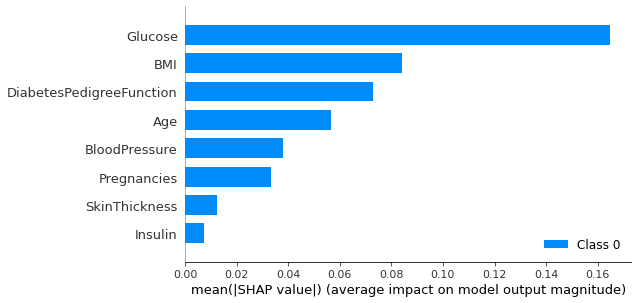

In [39]:
shap.summary_plot(shap_values, X_test_scaled, feature_names = features)